In [ ]:
import os
import pandas as pd


sample_path = "/blue/carpena/haasehelen/ifwaste/output/gsua_test/"
filename = "aggregated_outputs.csv"
df = pd.DataFrame()

foldernames = os.listdir(sample_path)
for folder in foldernames: 
    path = sample_path + folder + "/" + filename
    output = pd.read_csv(path)
    if len(df) == 0: 
        df = output
        df["run"] = int(folder.replace("run_", ""))
    else:
        output["run"] = int(folder.replace("run_", ""))
        df = pd.concat([df, output])
        
df["household"] = df["household"].astype(int)
df.head()

In [ ]:
#calculate the std of each item
#plot the std for when using 1..2..n runs 
#plot average change from 1 setting to another over all outputs (take MSE to not balance values out)
#track when <10% change over all outputs


### Compare robustness between runs m=1

In [ ]:
columns = df.columns.tolist()
columns.remove("household")
columns.remove("run")
#columns.remove("n_shop") #TODO insert again laters
#columns.remove("n_quickshop")

# Get sorted unique runs
run_values = sorted(df["run"].unique())

std_runs = mean_runs = {}

for max_run in run_values:
    df_subset = df[df["run"] <= max_run]  # cumulative subset of runs up to max_run
    stds = {f"std_{col}": df_subset[col].std() for col in columns}
    std_runs[f"run{max_run}"] = stds
    
    means = {f"std_{col}": df_subset[col].mean() for col in columns}
    mean_runs[f"run{max_run}"] = means
    break

# Convert to DataFrame
std_df = pd.DataFrame(std_runs).T  # transpose so each run is a row
mean_df = pd.DataFrame(mean_runs).T  # transpose so each run is a row


In [ ]:
std_df

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Compute mean and std per run
columns = df.columns.drop(["household", "run"])  # Define the columns you want to use

# Initialize mean and std DataFrames with the correct columns
mean_df = pd.DataFrame(columns=columns)
std_df = pd.DataFrame(columns=columns)

for i in range(1, df["run"].max() + 1):
    data_up_to_run = df[df["run"] <= i][columns]
    mean_df.loc[f"run{i}"] = data_up_to_run.mean()
    std_df.loc[f"run{i}"] = data_up_to_run.std()

# Step 2: Compute absolute relative change
mean_change = mean_df.pct_change().abs()
std_change = std_df.pct_change().abs()

# Step 3: Add boolean where ALL column changes < threshold
threshold = 0.10

mean_change['max_relative_change'] = mean_change[columns].max(axis=1)
std_change['max_relative_change'] = std_change[columns].max(axis=1)
# Step 4: Combine both to find stabilization point
both_below = (mean_change['max_relative_change'] < threshold) & (std_change['max_relative_change'] < threshold)
stabilization_run = both_below[both_below].index[0] if both_below.any() else None

print(f"First run where ALL std and mean changes are < 10%: {stabilization_run}")

# Step 5: Plot max relative change per run for both mean and std
plt.figure(figsize=(10, 6))

plt.plot(mean_change.index, mean_change['max_relative_change'], marker='o', label='Mean Max Rel. Change')
plt.plot(std_change.index, std_change['max_relative_change'], marker='x', label='Std Max Rel. Change')

# Draw stabilization line
#if stabilization_run:
#    plt.axvline(x=stabilization_run, color='red', linestyle='--', label=f'Stabilized at {stabilization_run}')

plt.title('Max Relative Change per Run (Mean & Std Deviation)')
plt.xlabel('Run')
plt.ylabel('Max Relative Change in Percent')
xticks = mean_change.index
plt.xticks(ticks=xticks[::5])  # adjust ::5 to change frequency

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
mean_change

### Compare robustness between flexible max runs (n) and run intervals (m)

### TODO -> m indexing wrong here!

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
First run where ALL std and mean changes are < 10%: run6


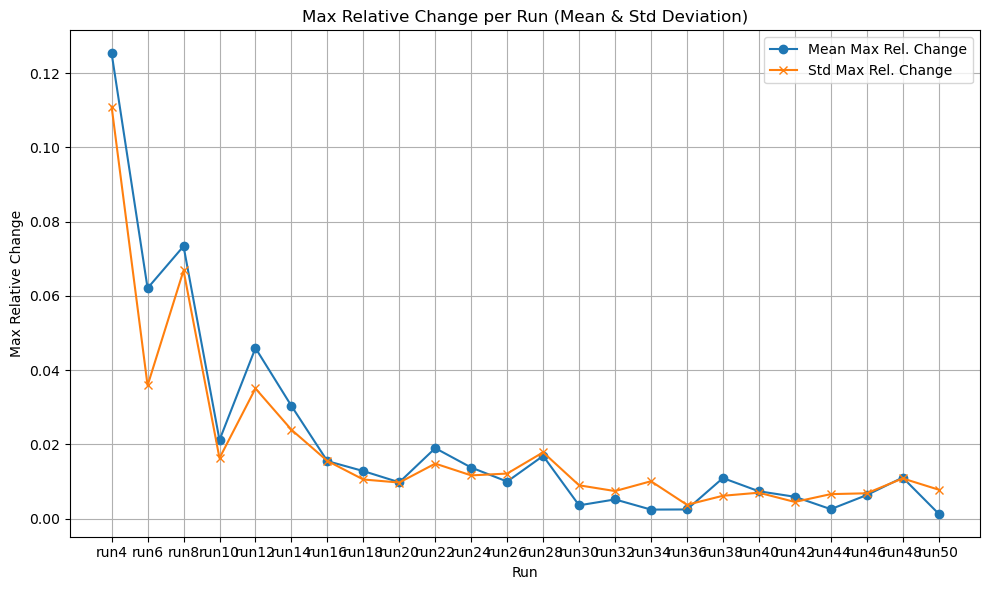

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the parameters
n = 50  # total number of runs
m = 2   # number of runs to skip between comparisons

# Define columns to use (excluding ID columns)
columns = df.columns.drop(["household", "run"])

# Step 1: Compute cumulative means and stds
mean_df = pd.DataFrame(columns=columns)
std_df = pd.DataFrame(columns=columns)

steps = list(range(m, n + 1, m)) 
print(steps)
for step in steps:
    subset = df[df["run"] <= step][columns]
    mean_df.loc[f"run{step}"] = subset.mean()
    std_df.loc[f"run{step}"] = subset.std()

# Step 2: Compute absolute relative change (manual, between cumulative windows)
mean_change = pd.DataFrame(columns=columns)
std_change = pd.DataFrame(columns=columns)

for i in range(1, len(steps)):
    prev_step = steps[i - 1]
    curr_step = steps[i]
    
    prev_mean = mean_df.loc[f"run{prev_step}"]
    curr_mean = mean_df.loc[f"run{curr_step}"]
    mean_change.loc[f"run{curr_step}"] = ((curr_mean - prev_mean) / prev_mean).abs()
    
    prev_std = std_df.loc[f"run{prev_step}"]
    curr_std = std_df.loc[f"run{curr_step}"]
    std_change.loc[f"run{curr_step}"] = ((curr_std - prev_std) / prev_std).abs()

# Step 3: Check for threshold stabilization
threshold = 0.10
mean_change["max_relative_change"] = mean_change.max(axis=1)
std_change["max_relative_change"] = std_change.max(axis=1)

both_below = (mean_change["max_relative_change"] < threshold) & (std_change["max_relative_change"] < threshold)
stabilization_run = both_below[both_below].index[0] if both_below.any() else None

print(f"First run where ALL std and mean changes are < 10%: {stabilization_run}")

# Step 4: Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean_change.index, mean_change["max_relative_change"], marker='o', label='Mean Max Rel. Change')
plt.plot(std_change.index, std_change["max_relative_change"], marker='x', label='Std Max Rel. Change')

#if stabilization_run:
#    plt.axvline(x=stabilization_run, color='red', linestyle='--', label=f'Stabilized at {stabilization_run}')

plt.title('Max Relative Change per Run (Mean & Std Deviation)')
plt.xlabel('Run')
plt.ylabel('Max Relative Change')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
